# Cell Clustering
The idea behind this notebook is to cluster the different types of cells we have inside a single class.
For this we will use the cells in the HEP annot folder.
Each class can be a composite of around 3-4 types of cells, from our studies. So it makes sense to differentiate between them so we can classify them better by studying their main characteristics by themselves.
For this type of clustering it is important to not filter the types of cells and get them raw.
The idea behind filtering is to remove the cells that are too different from the norm, so this way we can multiclass them.
The idea for this notebook is to classify the cells that are too different so that we can classify the overall image based on these differences.

# Utils

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import multiprocessing as mp
from sklearn.cluster import KMeans
# example of tending the vgg16 model
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import *
from keras.callbacks import EarlyStopping

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K


####
import random

from sklearn.decomposition import  KernelPCA, PCA
from sklearn.metrics.pairwise import rbf_kernel
from scipy import linalg

from sklearn.mixture import GaussianMixture

In [2]:

# import library
from google.colab import drive

#mount the drive
drive.mount('/content/drive')
# go to the url and get the password for the drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Image treatment

In [3]:
def transform_square(X):
  #Images are currently cropped around the cell, this function makes all cells have a black square around them with the same
  #size with the size of their largest dimension
  Xcopy = X.copy()
  for i in range(len(X)):
    #print(i)
    if X[i].shape[0] != X[i].shape[1]:
      max_dimension = max(X[i].shape[0],X[i].shape[1])
      aux = np.zeros((max_dimension, max_dimension))
      if max_dimension == X[i].shape[0]:
        margin = int((max_dimension - X[i].shape[1])/2)
        aux[:, margin: X[i].shape[1]+margin] = X[i]
      else:
        margin = int((max_dimension - X[i].shape[0])/2)
        aux[margin: X[i].shape[0]+margin, :] = X[i]
      Xcopy[i] = aux
  return Xcopy

def standardize_classes(X, y):
  Xcopy = X.copy()
  for i in range(len(y[0])): #iterating between 14 classes
    arr = np.where(y[:, i]==1)[0]
    max_dimension = 0
    for cell in X[arr]: #find the largest dimension in a given class
      max_dimension = max(cell.shape[0], max_dimension)
    for j in arr:
      aux = np.zeros((max_dimension, max_dimension))
      margin = int((max_dimension - X[j].shape[0])/2)
      aux[margin: margin + X[j].shape[0], margin: margin + X[j].shape[0]] = X[j]
      Xcopy[j] = aux
  return Xcopy

def resize_square(X, cnn_input_size, upscaling=False, full_size=True):
  # The resizing implemented is:
    # For smaller cells: no upscaling, just placing a smaller cell in a bigger black square if upscaling is false
      #If upscaling is true, then it upscales
    # for bigger cells: downscaling
  if full_size:
    Xcopy = np.zeros((len(X), cnn_input_size, cnn_input_size))
    for i in range(len(X)):
      aux = cv2.resize(X[i], dsize=(cnn_input_size, cnn_input_size), interpolation=cv2.INTER_CUBIC)
      Xcopy[i] = np.asarray(aux, 'float32')
    return Xcopy
  if upscaling==True:
    X = standardize_classes(X, y)
  Xcopy = np.zeros((len(X), cnn_input_size, cnn_input_size))
  for i in range(len(X)):
    if X[i].shape[0] < cnn_input_size and upscaling==False:
      aux = np.zeros((cnn_input_size, cnn_input_size))
      margin = int((cnn_input_size - X[i].shape[0])/2)
      aux[margin: margin + X[i].shape[0], margin: margin + X[i].shape[0]] = X[i]
    elif X[i].shape[0] >= cnn_input_size or upscaling==True:
      aux = cv2.resize(X[i], dsize=(cnn_input_size, cnn_input_size), interpolation=cv2.INTER_CUBIC)
    Xcopy[i] = np.asarray(aux, 'float16')
  return Xcopy

def grayscale_2_3channel(X):
    #copies grayscale into other channels for VGG
    return np.repeat(np.expand_dims(X, 3), 3, axis=3)
  
def normalize(X):
    for idx, img in enumerate(X):
        ar = np.array(img).astype(np.float32)
        mn = np.min(ar)
        mx = np.max(ar)
        X[idx] = (ar - mn) * (1.0 / (mx - mn))
    return X

def get_cells(path):
    print("Loading cells")
    X = []
    number_of_images = 0
    count = 0
    for idx, np_cells in enumerate((glob.glob(path + '/*'))):#iterating for every numpy array
        if np_cells[-5]=='G':
            a = np.load(np_cells, allow_pickle=True) #gets array from drive
            print(f'{np_cells[len(path)+1:]} - {len(a)}') 
            number_of_images += len(a)
                        
            #histogram construction
            for img in a:
                X.append(img[:,:,0])
                
    return X, number_of_images

def data_preparation (X, image_reshape_size, gray_to3=True):
    print('Normalizing images')
    #imgs_normalized = normalize(X)
    print("Making cells square")
    square = transform_square(X)
    print("Resizing to the correct size for classification")
    res_square = resize_square(square, image_reshape_size)
    #print(np.max(res_square))
    if gray_to3:
        print('Grayscale to 3 channels')
        cells = grayscale_2_3channel(res_square)
        return cells
    return res_square


## Transfer learning pretreatment

In [4]:
def extract_vector(X, model):
    resnet_feature_list = []
    for img in X:
        i = np.expand_dims(img.copy(), axis=0)
        resnet_feature_list.append(np.ravel(model.predict(i)))
    return np.array(resnet_feature_list)

# Transfer learning K-means
Here we apply the VGG transformation, then output vector probabilities of the neural networks by extracting the second to last layer of the pretrained neural network.
We use Kmeans ++.

In [5]:
#  params
path =  '/content/drive/MyDrive/Images/Cells/Full_image_cells/Cyto atypique MDA5'
image_reshape_size = 96

# make moddel
model = Sequential()
model.add(VGG16(include_top=False, input_shape=(image_reshape_size, image_reshape_size, 3), weights = 'imagenet'))

# Say not to train first layer (ResNet) model. It is already trained
model.layers[0].trainable = False


# prepare dataset
X_untreated, n_images = get_cells(path)
print(f'Number of cells: {n_images}')
X = data_preparation(X_untreated, image_reshape_size, gray_to3=True)
X_features = extract_vector(X, model)

print(X_features.shape)




58900480/58889256 [==============================] - 0s 0us/step
Loading cells
Cyto atypique MDA5_1G.npy - 44
Cyto atypique MDA5_2G.npy - 77
Cyto atypique MDA5_3G.npy - 30
Cyto atypique MDA5_4G.npy - 39
Cyto atypique MDA5_5G.npy - 24
Cyto atypique MDA5_6G.npy - 34
Cyto atypique MDA5_7G.npy - 94
Cyto atypique MDA5_8G.npy - 65
Cyto atypique MDA5_9G.npy - 54
Cyto atypique MDA5_10G.npy - 53
Cyto atypique MDA5_11G.npy - 51
Cyto atypique MDA5_12G.npy - 89
Cyto atypique MDA5_13G.npy - 31
Cyto atypique MDA5_14G.npy - 41
Cyto atypique MDA5_15G.npy - 48
Cyto atypique MDA5_16G.npy - 80
Cyto atypique MDA5_17G.npy - 54
Cyto atypique MDA5_18G.npy - 48
Cyto atypique MDA5_19G.npy - 65
Cyto atypique MDA5_20G.npy - 66
Cyto atypique MDA5_21G.npy - 66
Cyto atypique MDA5_22G.npy - 80
Cyto atypique MDA5_23G.npy - 65
Cyto atypique MDA5_24G.npy - 74
Cyto atypique MDA5_25G.npy - 57
Cyto atypique MDA5_26G.npy - 60
Cyto atypique MDA5_27G.npy - 35
Cyto atypique MDA5_28G.npy - 37
Cyto atypique MDA5_29G.npy - 53
Cy

In [6]:
n_clusters=3
# perform K_means
kmeans = KMeans(n_clusters, random_state=0).fit(X_features)
print(kmeans.labels_)

[1 0 1 ... 1 0 1]


In [46]:
# plot results
def plot_clusters(X, n_clusters, labels, image_reshape_size, n=2):
    import warnings
    image = np.zeros((image_reshape_size, image_reshape_size, 3))
    for i in range(n_clusters):
        plt.figure(figsize=(15,15)).suptitle(f'Cluster {i}')
        imgs = X[labels==i]
        len = imgs.shape[0]
        print(f'Number of cells in cluster {i}: {len}')
        for j in range(n):
            r = random.randint(0, len-1)
            plt.subplot(n//2,2, j+1)
            image[:,:,1] = np.clip((np.copy(imgs[r][:,:,0]))/255, 0, 1)
            plt.imshow(image)
        plt.show()

Number of cells in cluster 0: 1367


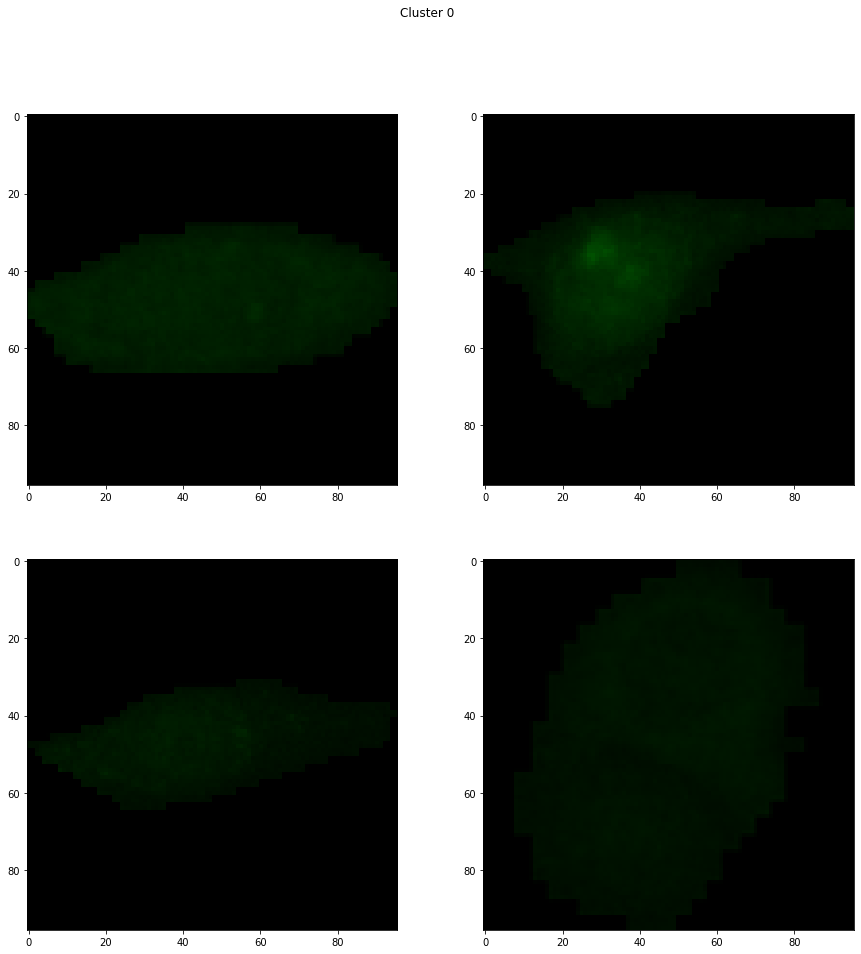

Number of cells in cluster 1: 1099


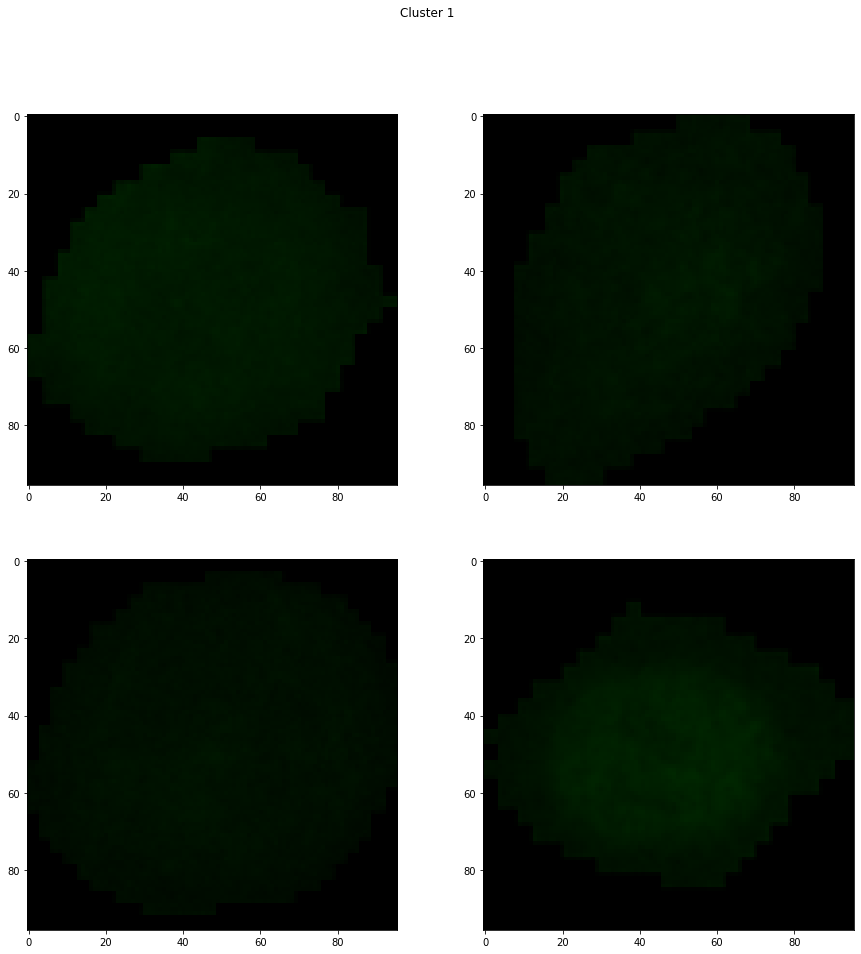

Number of cells in cluster 2: 95


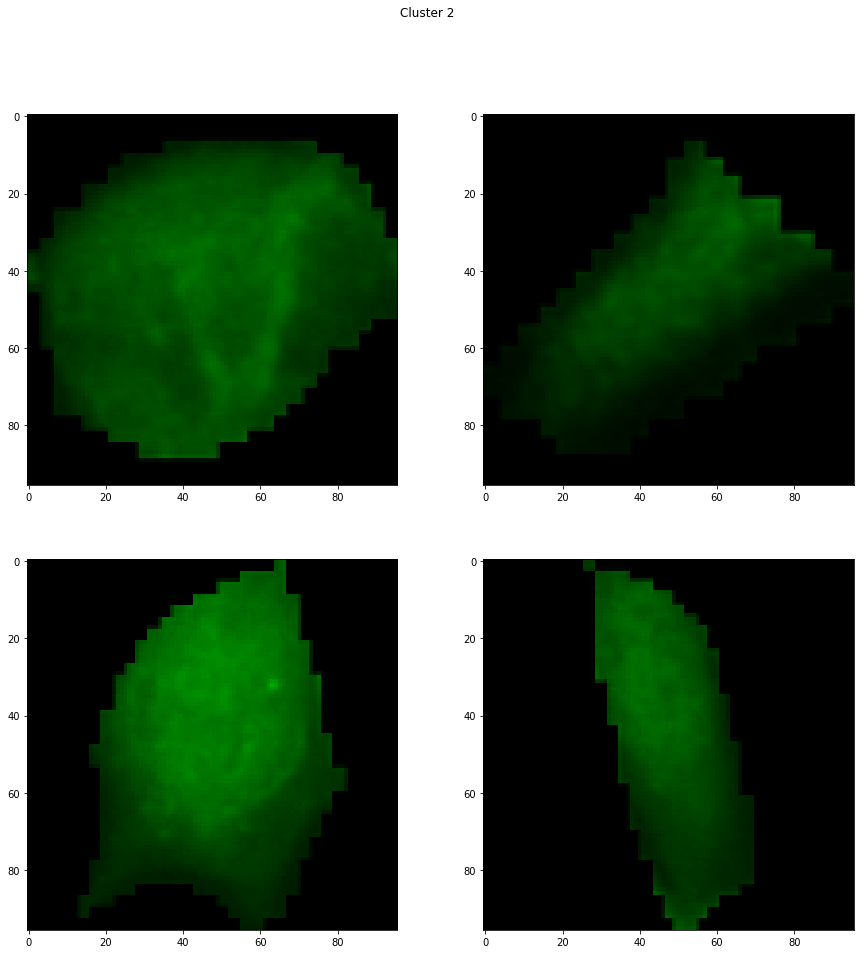

In [8]:
plot_clusters(X, n_clusters, kmeans.labels_, image_reshape_size)

Here for the best k parameter we use The Elbow Method and The Silhouette Method

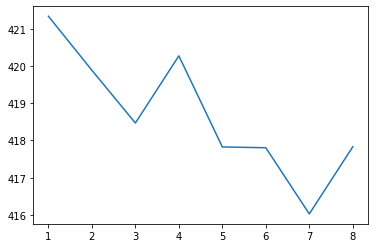

In [9]:
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k, random_state=0).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse
kmax = 8
sse = calculate_WSS(X_features, kmax)
plt.plot(range(1,1+kmax),sse)
plt.show()

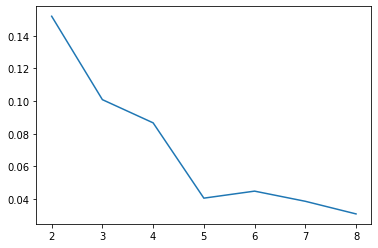

In [10]:

from sklearn.metrics import silhouette_score

def calculate_sil(x, kmax):
    # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
    sil =[]
    for k in range(2, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(x)
        labels = kmeans.labels_
        sil.append(silhouette_score(x, labels, metric = 'euclidean'))
    return sil

sil = calculate_sil(X_features, kmax)
plt.plot(range(2,1+kmax),sil)
plt.show()

Here we see that the images don't have clear clusters as the siluete method doesn't point to a maximum and the elbow method has several elbows, pointing to various possible number k of clusters.

# Gaussian mixture


In [11]:
model = GaussianMixture(n_components=n_clusters)
labels = model.fit_predict(X_features)



Number of cells in cluster 0: 1115


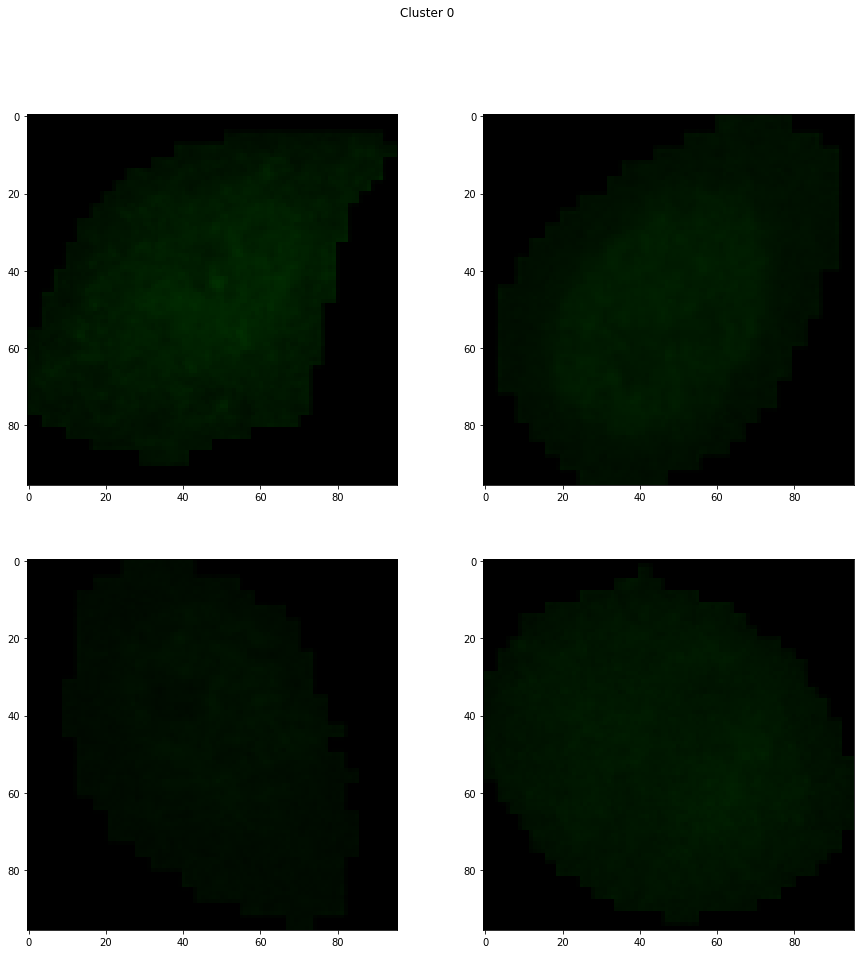

Number of cells in cluster 1: 1348


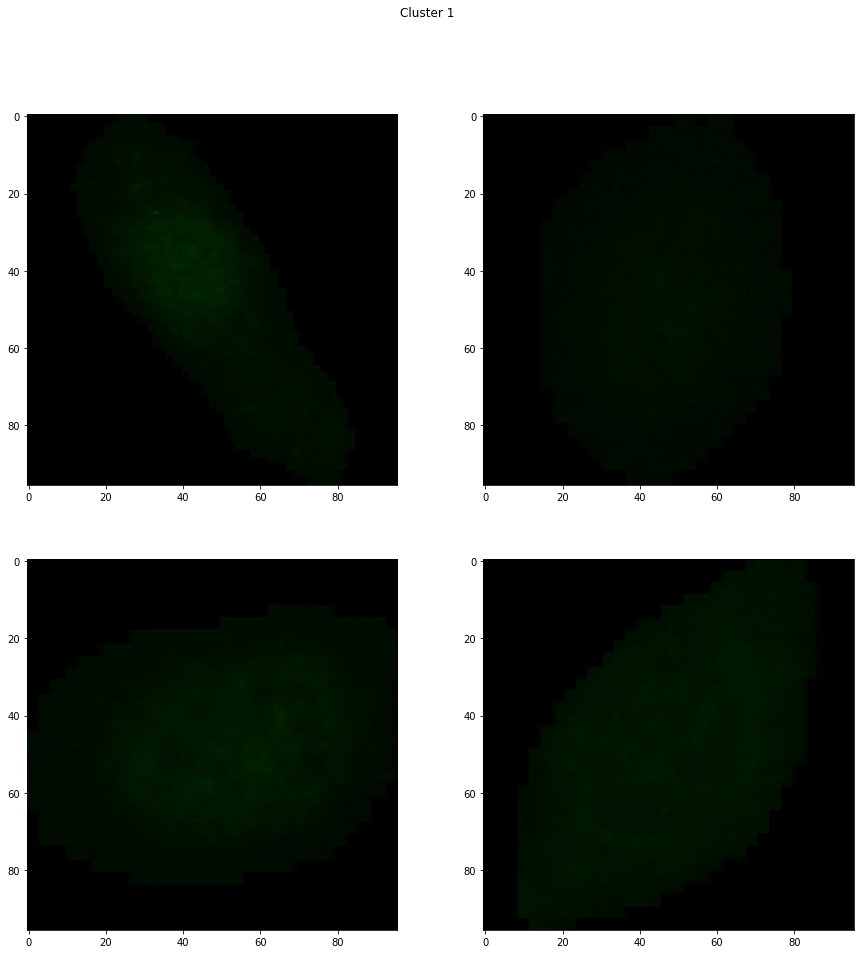

Number of cells in cluster 2: 98


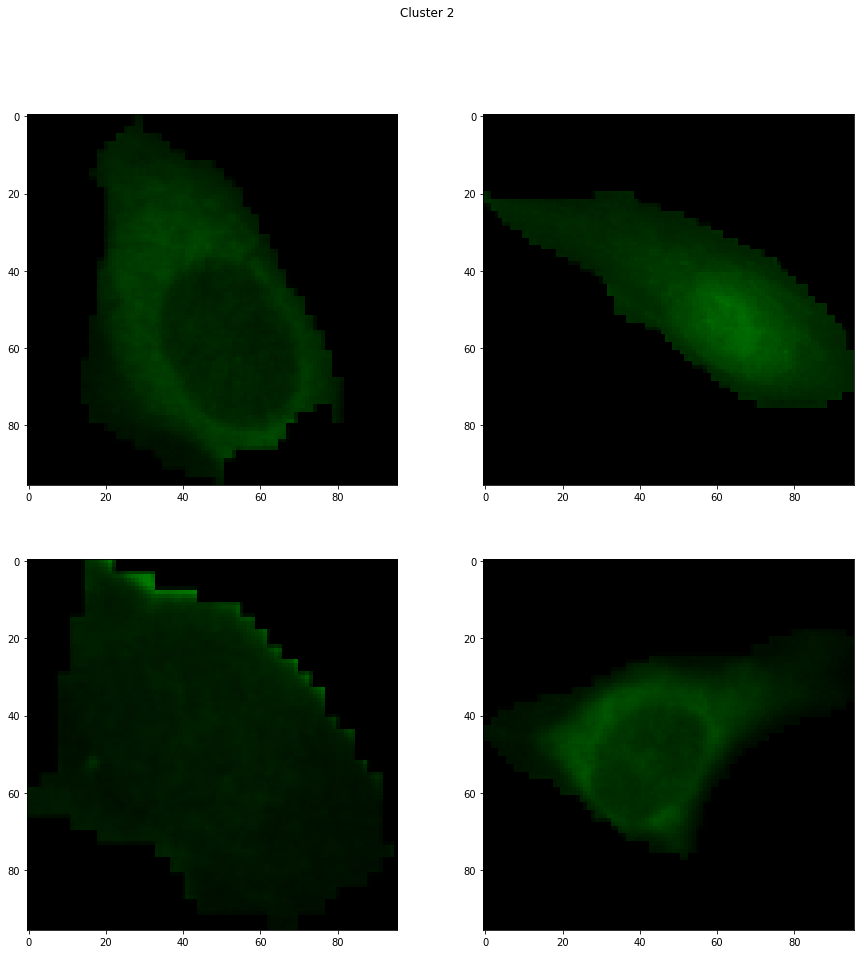

In [12]:
plot_clusters(X, n_clusters, labels, image_reshape_size)

# K-means with kpca using nystrom precomputation
Here we create a gaussian kernel using Nystrom random subsampling them use the Kmeans method on the vector feature space $\phi$, generated by the kernel trick. We chose not to use random fourier features for the kernel generation, because nystroms method generally has better results and for time management  reasons.


**Nystrom:**

We approximate the full kernel matrix $K$ for n samples, where:

$$K = [\kappa (x_i, x_j )]_{nxn}$$

First we sample $d$ points from the original dataset X, which we denote by $\hat{X} = [\hat{x}_1, ..., \hat{x}_d]$.

Construct a low rank matrix of rank $r$ by:

$$\hat{K}_r =K_d\hat{K}^{inv}K^T_d$$

Where $\hat{K}^{inv}$ is the pseudo inverse of $\hat{K}$, the full kernel matrix of the sampled points, using SVD decomposition. 

$$\hat{K} = [\kappa(\hat{x}_i, \hat{x}_j )]_{d×d}$$

And $K_d$ is the partial kernel matrix for the d sampled points in relation to the original n samples.

$$K_d = [\kappa(x_i, \hat{x}_j )]_{n×d}$$

From the low rank matrix we create a vector space $z_n(x)$.


$$z_n(x) = \hat{D}^{−1/2}_r \hat{V}^T_r(κ(x, \hat{x}_1), . . . , κ(x, \hat{x}_d))>$$

Where $\hat{D}_r = diag(\hat{λ}_1, . . . , \hat{λ}_r)$ and
$\hat{V}_r = (\hat{v}_1, . . . , \hat{v}_r)$, from:

$z_n(x_i)^Tz_n(x_j) = [\hat{K}_r]_{ij}$


This precomputation of the kernel is linear and should improove the transfer learned 

In [51]:
def nystrom_approximation(x_train, x_test, d, r=200, gamma=0.00001, test=False):
    # sample and make kernel 
    rng = np.random.RandomState(42)
    n_samples = x_train.shape[0]
    idx = rng.choice(n_samples, d)

    x_train_idx = x_train[idx, :]
    K_hat = rbf_kernel(x_train_idx, x_train_idx, gamma=gamma)
    
    # svd 
    u, s, vt = linalg.svd(K_hat, full_matrices=False)
    u = u[:,:r]
    s = s[:r]
    vt = vt[:r, :]
    M = np.dot(u, np.diag(1/np.sqrt(s)))
    
    # partial kernel 
    nystrom_train = rbf_kernel(x_train, x_train_idx, gamma=gamma)
    x_new_train = np.dot(nystrom_train, M)
    
    if test:
        nystrom_test = rbf_kernel(x_test, x_train_idx, gamma=gamma)
        x_new_test = np.dot(nystrom_test, M)
        return x_new_train, x_new_test
    
    return x_new_train

# dimention of d points

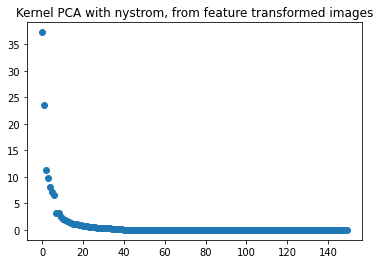

In [60]:

d = 40

z = nystrom_approximation(X_features,_ , d)
K = z@z.T

kpca = KernelPCA(kernel="precomputed",n_components=150, gamma=0.00001)
X_kpca = kpca.fit_transform(K)

plt.figure()
plt.title("Kernel PCA with nystrom, from feature transformed images")
plt.scatter(range(len(kpca.eigenvalues_)), kpca.eigenvalues_)
plt.show()

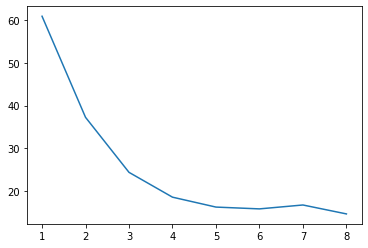

In [61]:
sse = calculate_WSS(X_kpca, kmax)
plt.plot(range(1,1+kmax),sse)
plt.show()

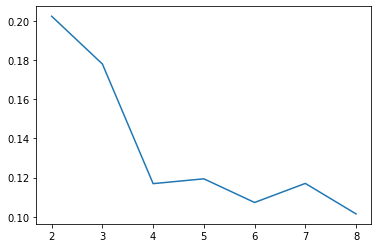

In [63]:
sil = calculate_sil(X_kpca, kmax)
plt.plot(range(2,1+kmax),sil)
plt.show()

Number of cells in cluster 0: 103


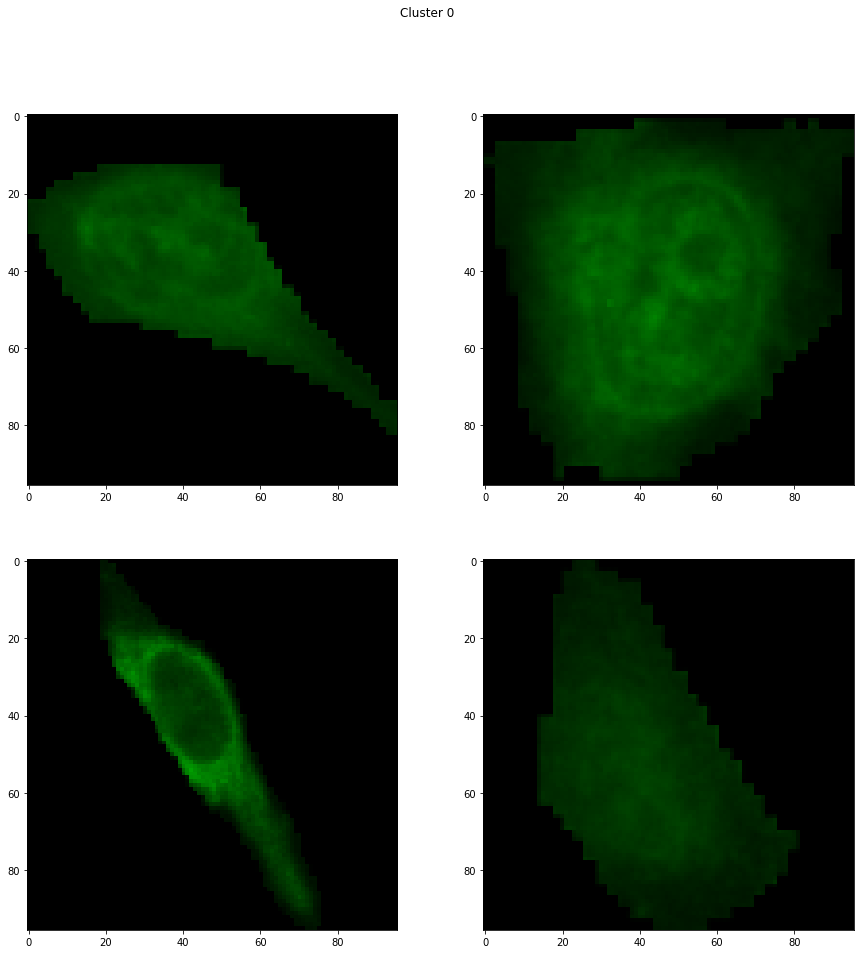

Number of cells in cluster 1: 1110


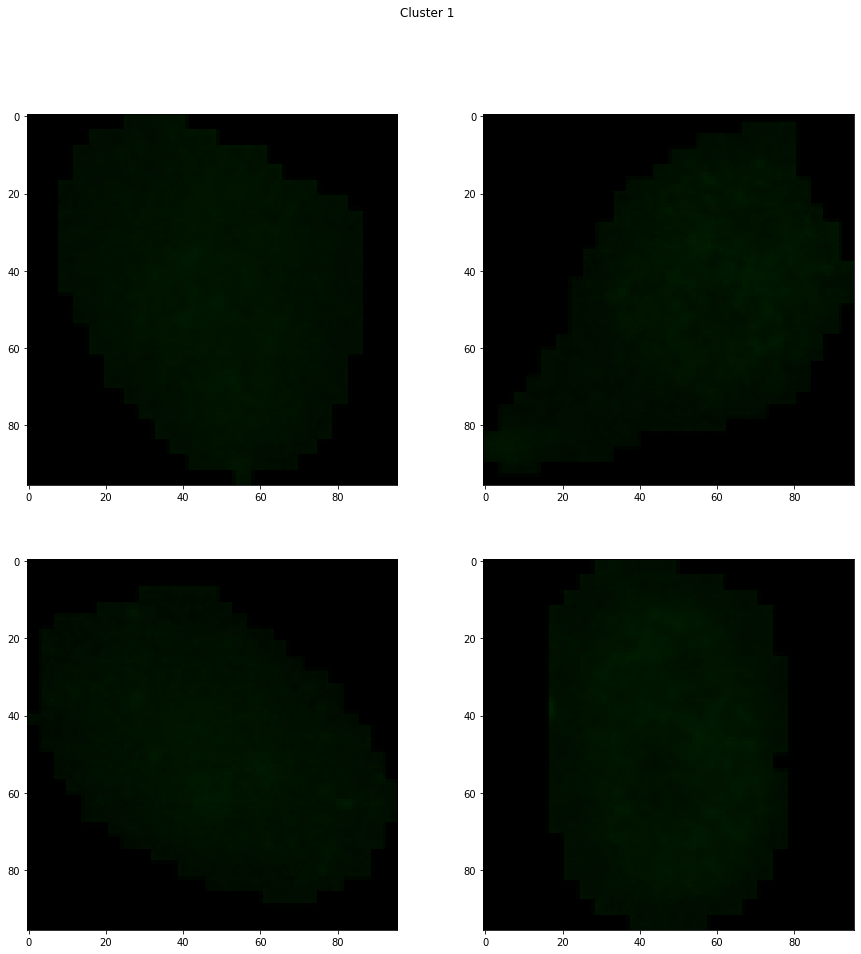

Number of cells in cluster 2: 1348


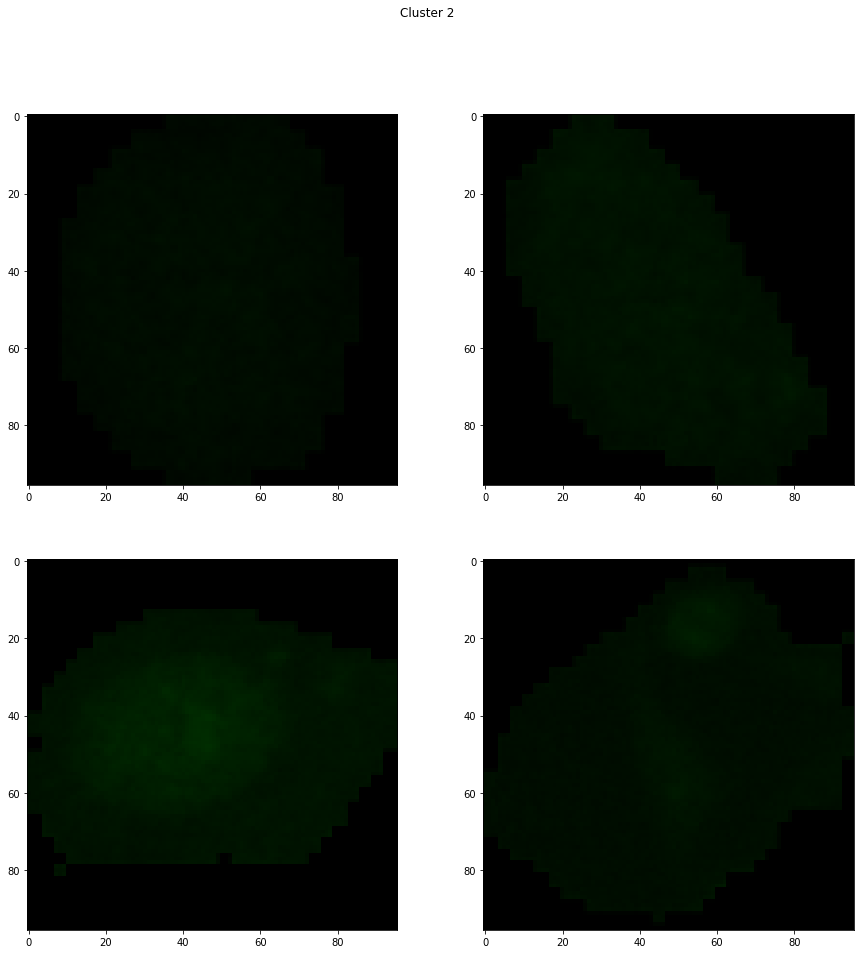

In [54]:
plot_clusters(X, n_clusters, kmeans.labels_, image_reshape_size, 4)

Normalizing images
Making cells square
Resizing to the correct size for classification


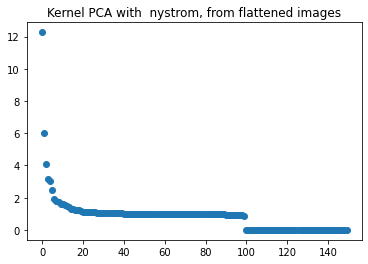

In [58]:

from sklearn.kernel_approximation import Nystroem
X_flat = data_preparation(X_untreated, image_reshape_size, gray_to3=False).reshape((X.shape[0],image_reshape_size*image_reshape_size))
feature_map_nystroem = Nystroem(gamma=0.00001, random_state=1, n_components=100)
z_nys = feature_map_nystroem.fit_transform(X_flat)

K_nys = z_nys@z_nys.T
kpca = KernelPCA(kernel="precomputed",n_components=150, gamma=0.00001)
X_kpca = kpca.fit_transform(K_nys)

plt.figure()
plt.title("Kernel PCA with nystrom, from flattened images")
plt.scatter(range(len(kpca.eigenvalues_)), kpca.eigenvalues_)
plt.show()

Number of cells in cluster 0: 103


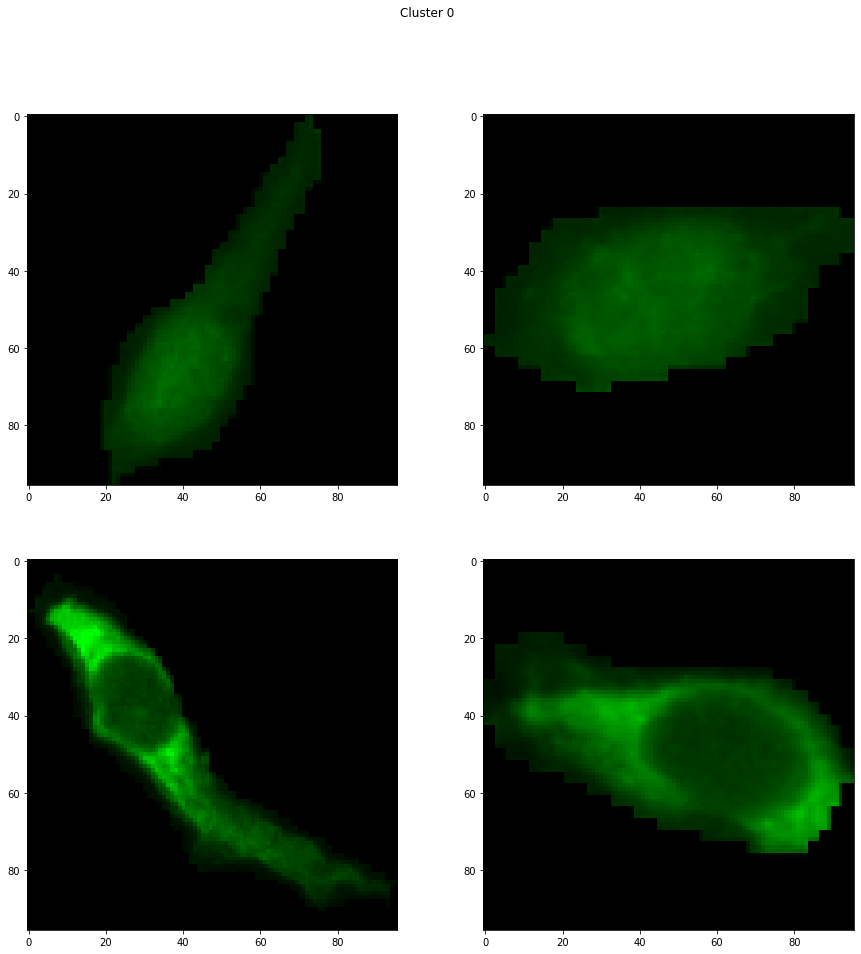

Number of cells in cluster 1: 1110


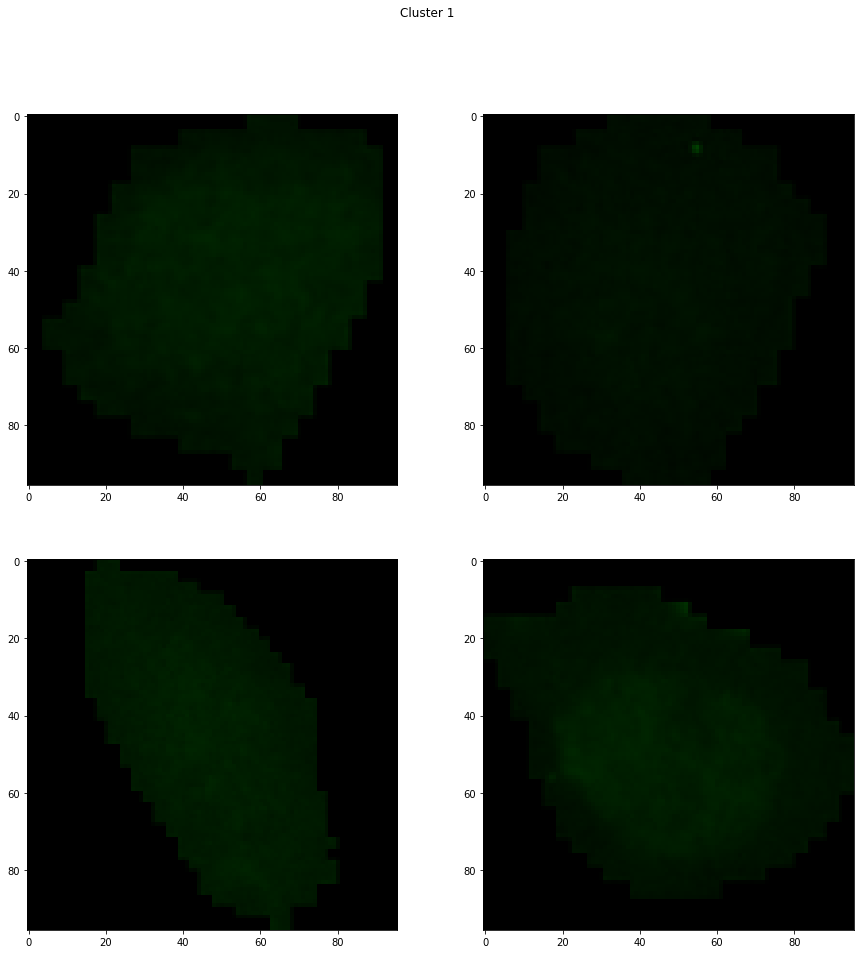

Number of cells in cluster 2: 1348


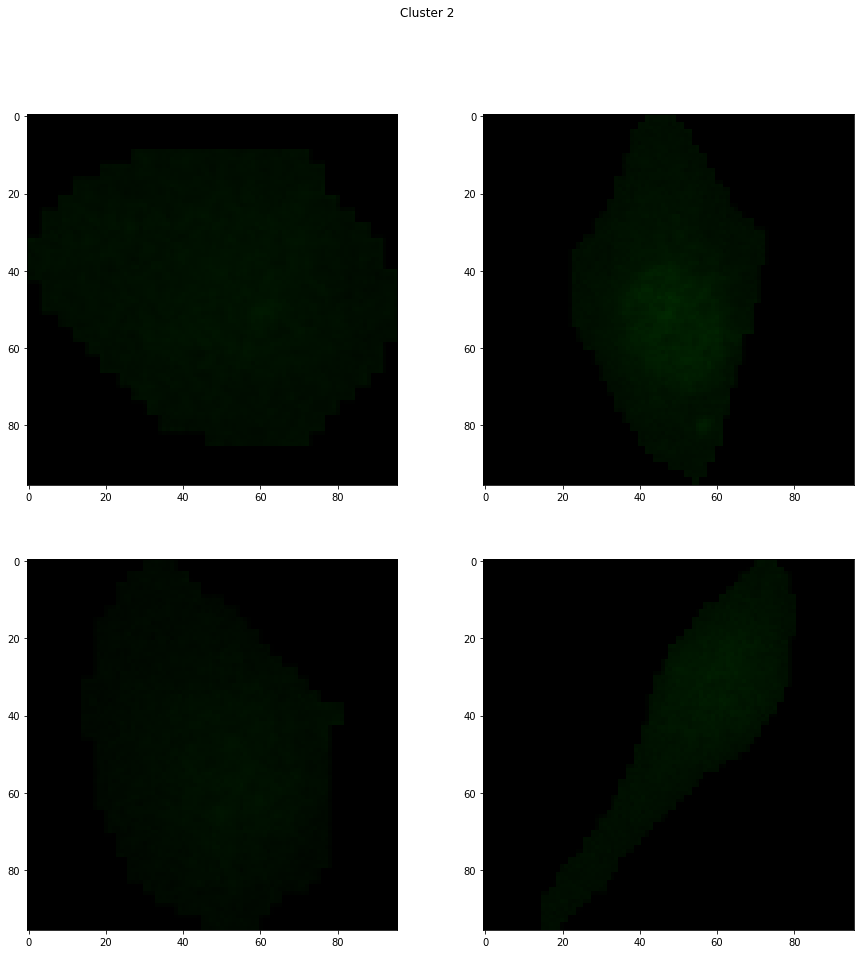

In [50]:
plot_clusters(X, n_clusters, kmeans.labels_, image_reshape_size, 4)

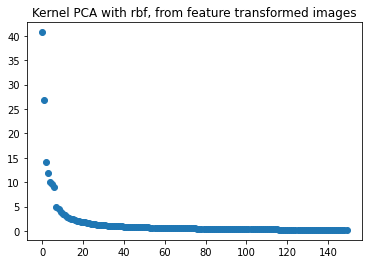

In [64]:

kpca = KernelPCA(kernel="rbf",n_components=150, gamma=0.00001)
X_kpca = kpca.fit_transform(X_features)

plt.figure()
plt.title("Kernel PCA with rbf, from feature transformed images")
plt.scatter(range(len(kpca.eigenvalues_)), kpca.eigenvalues_)
plt.show()

In [42]:
n_clusters=3
# perform K_means
kmeans = KMeans(n_clusters, random_state=0).fit(X_kpca)
print(kmeans.labels_)

[1 2 1 ... 1 2 1]


Number of cells in cluster 0: 103


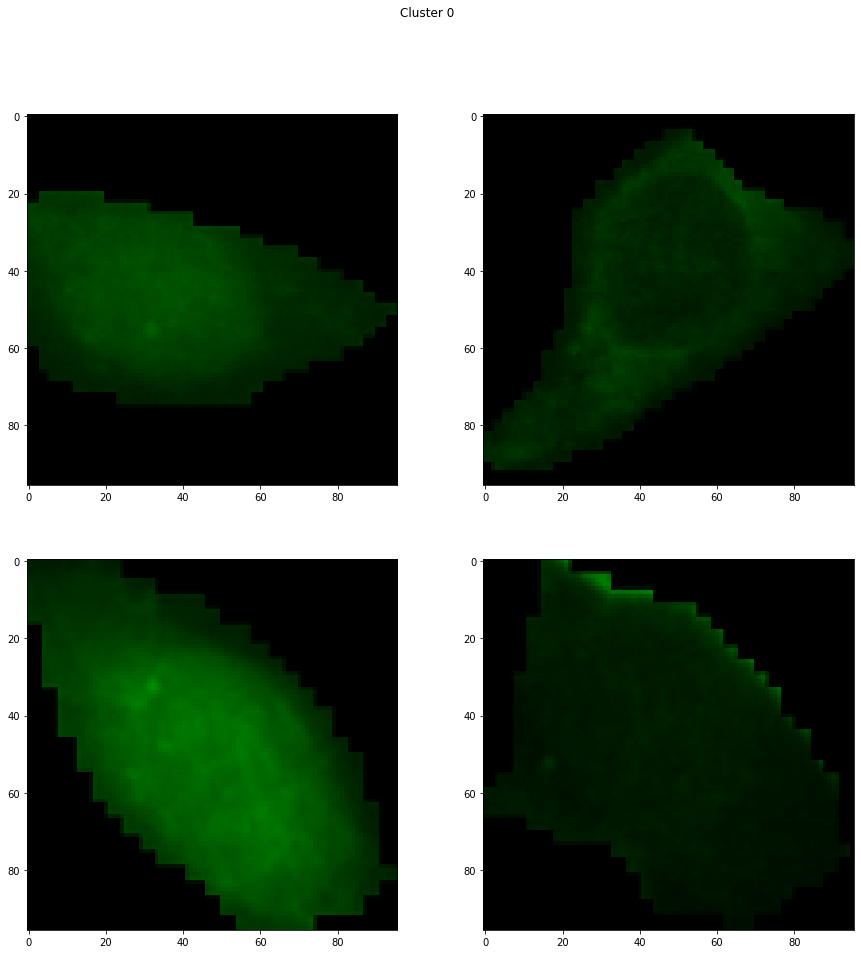

Number of cells in cluster 1: 1110


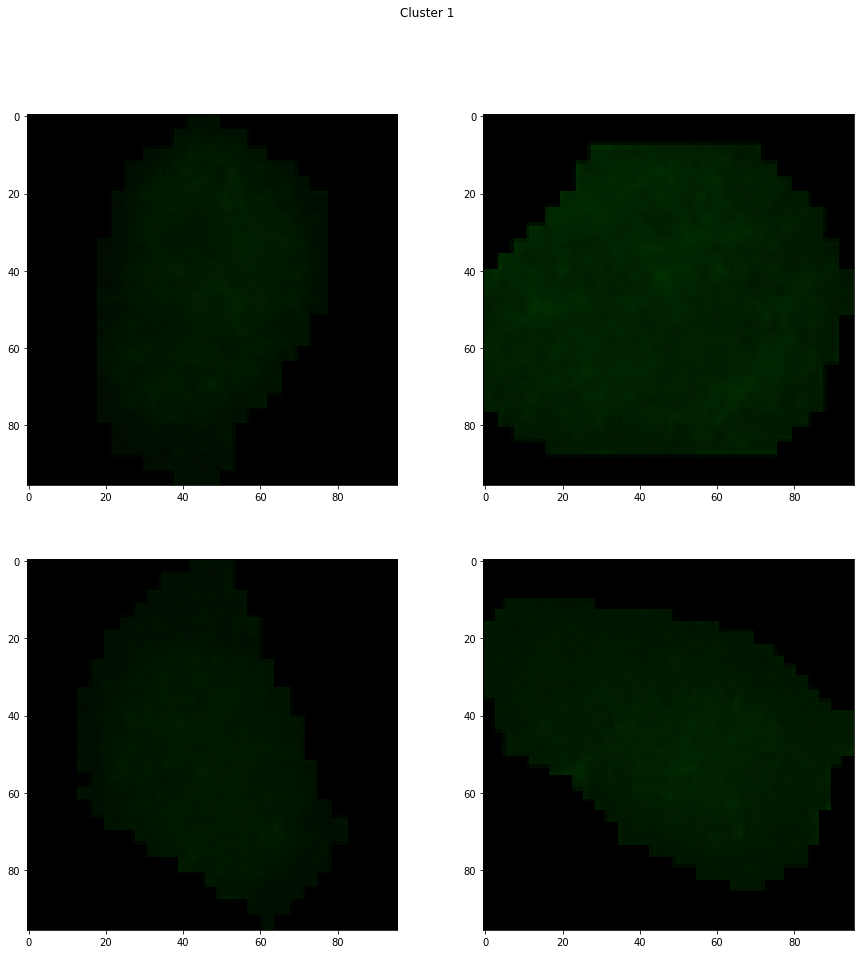

Number of cells in cluster 2: 1348


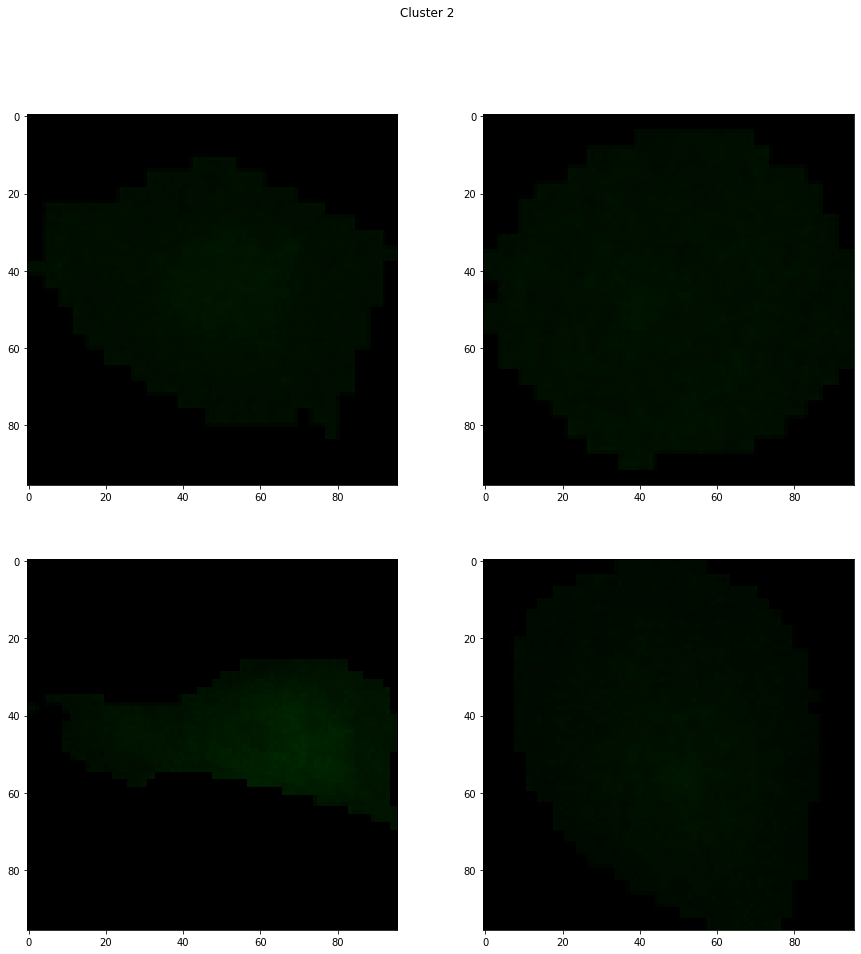

In [44]:
plot_clusters(X, n_clusters, kmeans.labels_, image_reshape_size)

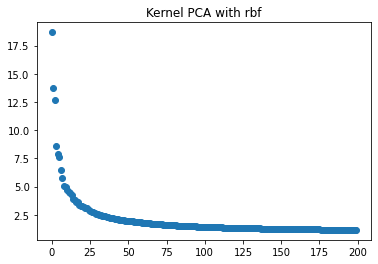

In [37]:

kpca = KernelPCA(kernel="rbf",n_components=200, gamma=0.00001)
X_kpca = kpca.fit_transform(X_flat)

plt.figure()
plt.title("Kernel PCA with rbf")
plt.scatter(range(len(kpca.eigenvalues_)), kpca.eigenvalues_)
plt.show()

In [38]:
n_clusters=3
# perform K_means
kmeans = KMeans(n_clusters, random_state=0).fit(X_kpca)
print(kmeans.labels_)

[0 0 0 ... 0 0 1]


Number of cells in cluster 0: 103


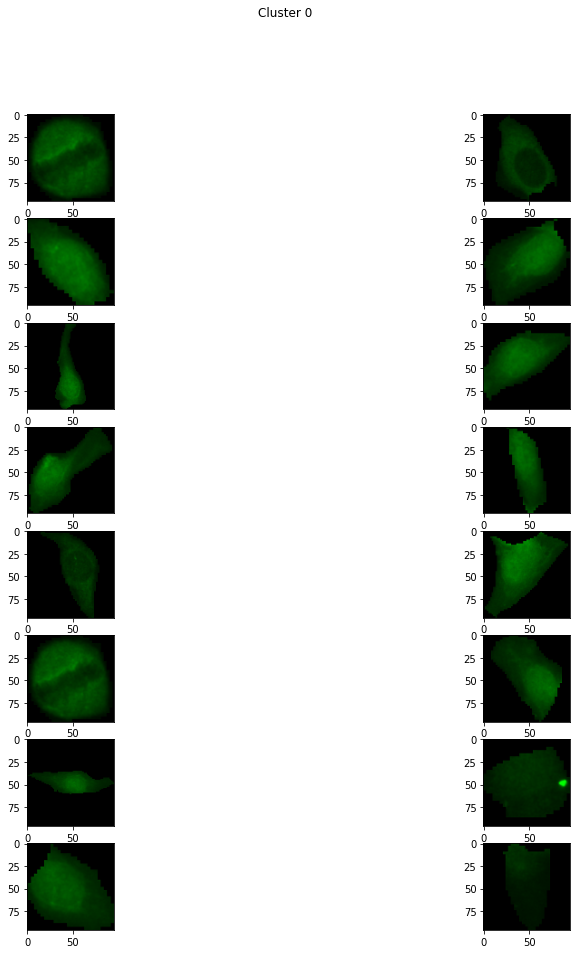

Number of cells in cluster 1: 1110


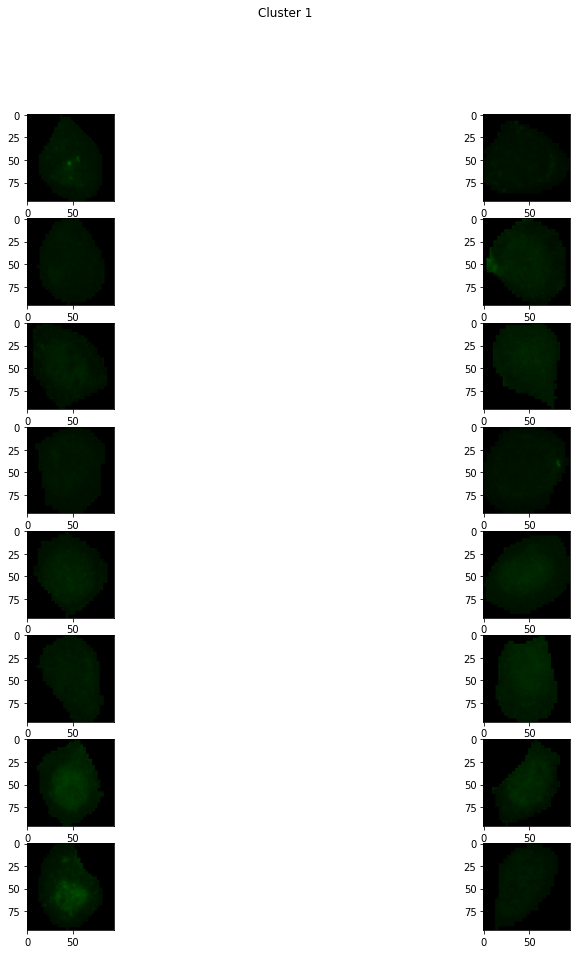

Number of cells in cluster 2: 1348


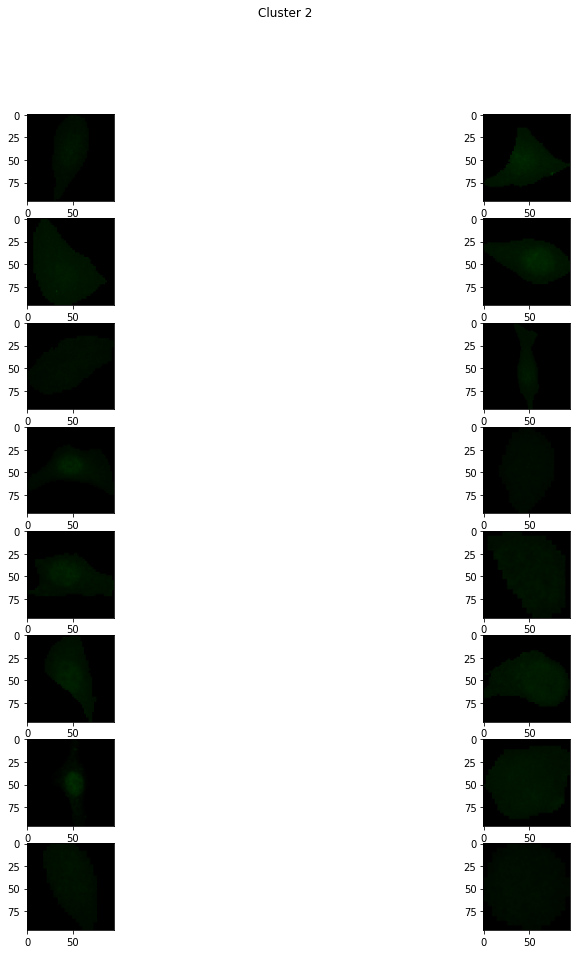

In [47]:
plot_clusters(X, n_clusters, kmeans.labels_, image_reshape_size,16)

# Conclusions:
The best methods are the gaussian mixture and kmeans on the features of the cnns output, but the gaussian mixture is very slow and should be avoided.